# Overview

Exercise is any physical activity that enhances or maintains physical fitness and overall health. It is an important part of a healthy lifestyle and can have numerous benefits for the body and mind. Some of the potential effects of exercising include:

1. Improved cardiovascular health: Regular exercise can help to improve the function of the heart and blood vessels, leading to a lower risk of heart disease, high blood pressure, and stroke.

2. Weight management: Exercise can help to increase metabolism, burn calories, and build muscle, which can help with weight management.

3. Stronger bones and muscles: Engaging in weight-bearing and resistance exercises can help to build and maintain strong bones and muscles.

4. Improved mental health: Exercise has been shown to reduce stress, improve mood, and boost self-esteem. It can also help to improve sleep quality.

5. Enhanced brain function: Some studies have suggested that exercise may improve cognitive function and protect against age-related declines in brain function.

Calories are a unit of energy that is used to measure the energy content of food. When we consume more calories than we burn through exercise and daily activities, our bodies store the excess as fat. On the other hand, when we burn more calories than we consume, our bodies can use stored fat as a source of energy, leading to weight loss. Therefore, monitoring calorie intake and expenditure can be an important part of a healthy lifestyle and weight management.

**Import modules**

In [1]:
import pandas as pd 
import sqlite3
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sqlalchemy import create_engine

**Loading Dataset**

In [2]:
df = pd.read_csv("/kaggle/input/calories-burned-during-exercise-and-activities/exercise_dataset.csv")
df.head()

,"Activity, Exercise or Sport (1 hour)",130 lb,155 lb,180 lb,205 lb,Calories per kg
0,"Cycling, mountain bike, bmx",502,598,695,791,1.750730
1,"Cycling, <10 mph, leisure bicycling",236,281,327,372,0.823236
2,"Cycling, >20 mph, racing",944,1126,1308,1489,3.294974
3,"Cycling, 10-11.9 mph, light",354,422,490,558,1.234853
4,"Cycling, 12-13.9 mph, moderate",472,563,654,745,1.647825


In [3]:
df.columns

Index(['Activity, Exercise or Sport (1 hour)', '130 lb', '155 lb', '180 lb',
       '205 lb', 'Calories per kg'],
      dtype='object')

The column names of the table are very long and do not follow the standard naming conventions. We should change the column names to follow the proper conventions at a later time.

**Check Null Values**

In [4]:
df.isnull().sum()

Activity, Exercise or Sport (1 hour)    0
130 lb                                  0
155 lb                                  0
180 lb                                  0
205 lb                                  0
Calories per kg                         0
dtype: int64

Good thing to know that there are no null values in this dataset.

**Change Column Name**

The column names in the dataset are long and some of them begin with a number, which means they cannot be used as SQL commands. In order to use them in SQL, we need to change the column names to follow the standard naming conventions.

In [5]:
#change column name
df.rename(columns = {'Activity, Exercise or Sport (1 hour)': 'Exercise', 'Calories per kg':'Calorieskg'
                    ,'130 lb':'lb130','155 lb':'lb155','180 lb':'lb180','205 lb':'lb205'}, inplace = True)

In [6]:
df.columns

Index(['Exercise', 'lb130', 'lb155', 'lb180', 'lb205', 'Calorieskg'], dtype='object')

In [7]:
df.describe()

,lb130,lb155,lb180,lb205,Calorieskg
count,248.000000,248.000000,248.000000,248.000000,248.000000
mean,389.754032,464.689516,539.685484,614.620968,1.359930
std,194.434028,232.019135,269.430029,306.847470,0.678851
min,89.000000,106.000000,123.000000,140.000000,0.310067
25%,236.000000,281.000000,327.000000,372.000000,0.823236
50%,354.000000,422.000000,490.000000,558.000000,1.234853
75%,472.000000,563.000000,654.000000,745.000000,1.647825
max,1062.000000,1267.000000,1471.000000,1675.000000,3.706591


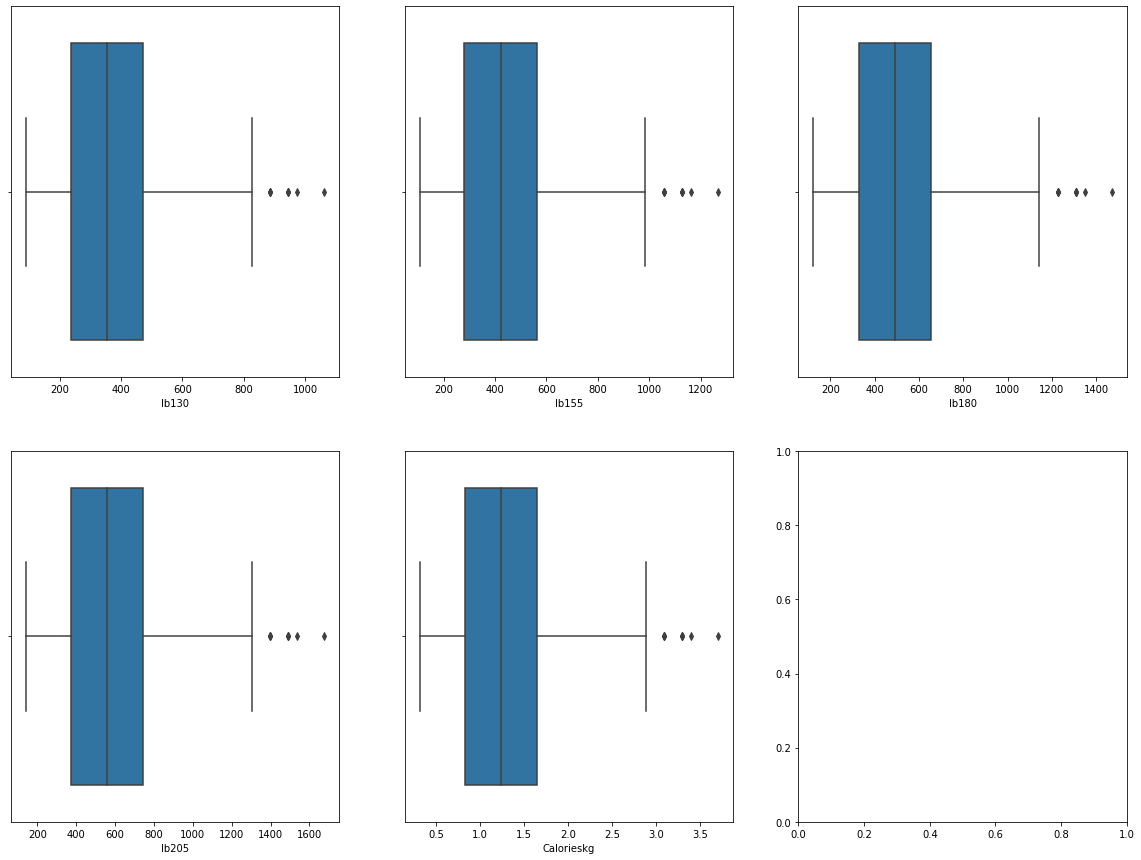

In [8]:
numerical = ['lb130', 'lb155', 'lb180', 'lb205', 'Calorieskg']
fig,ax1 = plt.subplots(2,3,figsize = (20,15))
for i in range(0,len(numerical)):
    sns.boxplot(x=df[numerical[i]],ax=ax1[i//3, i%3])

There are some outliers in all of the columns, and the number of outliers is the same in each column. This suggests that the data is linear and that one element, specifically the weight/pounds, is responsible for scaling the numerical values in the dataframe.

# Data Manipulation

**Unique Exercises Data**

It is quite evident that the Exercise column contains a significant amount of data or words. Upon closer inspection, we can see that the Exercises column is separated by commas. The first word in each row typically refers to the specific exercise being performed, while the subsequent words provide additional details such as the intensity of the exercise and the type of activity. It seems that this organization allows for a clear and concise way to present the various exercises and related information in the column.

The first step that we have to do is to split the Exercise column with comma as the separator, and figure out the unique exercise listed.

In [9]:
sep = df['Exercise'].str.split(',')
unique_exercises = []
for i in range(0,len(sep)):
    if sep[i][0] not in unique_exercises:
        unique_exercises.append(sep[i][0])
print(f"There are {len(unique_exercises)} unique exercises in this data set")

There are 167 unique exercises in this data set


The next step in our task is to calculate the mean number of calories burned for each unique exercise listed in the Exercise column. In addition to this, we also need to determine the frequency at which each unique exercise appears in the Exercise column. This will allow us to get a better understanding of the most common exercises being performed and how many calories they tend to burn on average.

In [10]:
calories_burned = {}
for exercise in unique_exercises:
    for key,i in enumerate(df['Exercise']):
        if exercise not in calories_burned:
            calories_burned[exercise] = 0
        if exercise in i:
            calories_burned[exercise] += df['Calorieskg'][key]

In [11]:
#figure out how to get mean of calorieskg per exercise
exercise_num_occurrence = {}
for exercise in unique_exercises:
    for key,i in enumerate(df['Exercise']):
        if exercise not in exercise_num_occurrence:
            exercise_num_occurrence[exercise] = 0
        if exercise in i:
            exercise_num_occurrence[exercise] += 1

# get mean value of of calories burned of each unique exercises
for i in unique_exercises:
    calories_burned[i] = calories_burned[i]/exercise_num_occurrence[i]

Now that we have our python dictionaries organized, the next step is to convert them into pandas dataframes. Once we have done this, we can merge the two dataframes together using pandas' merge function. This will allow us to combine the information from the calories_burned and exercise_num_occurrence dictionaries into a single dataframe for further analysis.

In [12]:
occurrence_df = pd.DataFrame(exercise_num_occurrence.items(), columns = ['Unique_exercise','Num_occurrence'])
unique_df = pd.DataFrame(calories_burned.items(), columns = ['Unique_exercise','Mean_calories_per_kg'])

#combine dataset
df1 = unique_df.merge(occurrence_df, on = "Unique_exercise")

The next step in our process is to use SQLAlchemy to convert the data from its current csv format into a sqlite database.

In [13]:
# convert data to sqlite
engine_df1 = create_engine('sqlite://', echo = False)
df1.to_sql('Exercise_Data', con = engine_df1)

**Exercise Intensity and Types Data**

In the Exercise column, there are various words that provide additional information about the type of exercise being performed. Our next step is to create a list of these keywords that appear in the Exercise column. Once we have compiled this list of keywords, we can use it to more accurately categorize and analyze the exercises listed in the column. This will provide us with a clearer understanding of the types of activities being performed and how they may be impacting the overall health and fitness of the individuals in the dataset.

In [14]:
unique_keywords = []
for i in range(0,len(sep)):
    if (sep[i][-1] in unique_exercises):
        pass
    elif sep[i][-1] not in unique_keywords:
        unique_keywords.append(sep[i][-1])
    
    if (len(sep[i]) > 2) and (sep[i][-2] in unique_exercises):
        pass
    elif (len(sep[i]) > 2) and sep[i][-2] not in unique_keywords:
        unique_keywords.append(sep[i][-2])
print(f"There are {len(unique_keywords)} unique keywords in this data set, excluding the exercise name")

There are 142 unique keywords in this data set, excluding the exercise name


For the next step, we will use Python's dictionary to find the unique keywords in the Exercise column and count how many times each keyword appears. This process is similar to what we did with the unique data in the Exercise column earlier.

In [15]:
#count the occurrence
frequency = {}
for keyword in unique_keywords:
    for key,i in enumerate(df['Exercise']):
        if keyword not in frequency:
                frequency[keyword] = 1
        elif keyword in i:
                frequency[keyword] += 1
check_error = [ans for ans in unique_exercises if ans in unique_keywords]
print(f"repeated keywords: {len(check_error)}. \nIf not 0: there is an error")

repeated keywords: 0. 
If not 0: there is an error


In [16]:
#figure out how to get mean of calorieskg per keyword
keyword_calburned = {}
for keyword in unique_keywords:
    for key,i in enumerate(df['Exercise']):
        if keyword not in keyword_calburned:
            keyword_calburned[keyword] = 0
        if keyword in i:
            keyword_calburned[keyword] += df["Calorieskg"][key]
# get mean value of of calories burned of each unique keywords
for i in unique_keywords:
    keyword_calburned[i] = keyword_calburned[i]/frequency[i]

In the final step for the exercise type and intensity section, we will create two dataframes: one for the frequency dictionary and one for the keyword_calburned dictionary. Then, we will merge these two dataframes into a single dataframe.

In [17]:
frequency_df = pd.DataFrame(frequency.items(), columns = ['Keyword','Frequency'])
keyword_occ_df = pd.DataFrame(keyword_calburned.items(), columns = ['Keyword','Mean_calburned'])

df2 = frequency_df.merge(keyword_occ_df, on = "Keyword")

In [18]:
#up keyword
df2.sort_values(by = 'Frequency', ascending = False).head(10)

,Keyword,Frequency,Mean_calburned
8,moderate,14,1.335533
10,vigorous,12,1.776174
6,light,10,0.726830
23,general,9,0.949610
43,up,9,1.635940
47,competitive,8,1.802013
27,slow,7,0.867821
28,fast,7,1.926944
134,walk,7,0.759210
74,walking,6,0.696975


After sorting the frequency data in descending order and examining the top 10 frequencies, we can observe two things: the keyword "up" is very ambiguous and needs further clarification, and we need to determine if there is any difference between "walking" and "walk."

In [19]:
# find the meaning of the keyword up
for i in df['Exercise']:
    if 'up' in i:
        print(i)

Calisthenics, vigorous, pushups, situps…
Running, stairs, up
Carrying infant, upstairs
Carrying 16 to 24 lbs, upstairs
Carrying 25 to 49 lbs, upstairs
Climbing hills, carrying up to 9 lbs
Walking 3.5 mph, uphill
Cross country skiing, uphill
Carrying moderate loads upstairs


From the code above, we can see that the keyword "up" refers to an inclination, such as climbing stairs or walking uphill. Next up is to combine the frequencies between the keyword "walk" and "walking as there are no difference between them.

In [20]:
#combine walk and walking
frequency_df.loc[134,'Frequency'] += frequency_df.loc[74,'Frequency']

Finally, convert the data that has a csv format to a SQLite format using SQLAlchemy.

In [21]:
engine_df2 = create_engine('sqlite://', echo = False)
df2.to_sql('Frequency_Data', con = engine_df2)

# Exploratory Data Analysis/SQL Queries

**Unique Exercise Data**

In this dataset, the Num_occurrence column starts at 1. To calculate the mean number of calories burned per kg of exercise, we need to divide the calories burned per kg by the number of occurrences in the dataset. However, exercises with only one occurrence may be more susceptible to outliers. Therefore, our query should include exercises with more than one occurrence, as well as those with only one occurrence.

In [22]:
pd.read_sql_query('''SELECT Unique_exercise, Mean_calories_per_kg, Num_occurrence 
                     FROM Exercise_Data LIMIT 5''', engine_df1)

,Unique_exercise,Mean_calories_per_kg,Num_occurrence
0,Cycling,1.897446,7
1,Unicycling,1.029722,1
2,Stationary cycling,1.585676,5
3,Calisthenics,1.184417,2
4,Circuit training,1.647825,1


**Top Performed Exercise**

Let's look at the exercises that were performed the most in the dataset

In [23]:
# sort dataframe descending order
pd.read_sql_query('''SELECT Unique_exercise, Mean_calories_per_kg, Num_occurrence FROM Exercise_Data 
                     ORDER BY Num_occurrence DESC, Mean_calories_per_kg DESC LIMIT 10''', engine_df1)

,Unique_exercise,Mean_calories_per_kg,Num_occurrence
0,Running,2.426167,16
1,Walking,0.858923,14
2,Swimming,1.668000,10
3,Cycling,1.897446,7
4,Golf,0.782728,6
5,Stationary cycling,1.585676,5
6,Cross country skiing,2.445335,4
7,Climbing hills,1.621761,4
8,Rowing machine,1.596035,4
9,Aerobics,1.390056,4


In [24]:
#top ten by  occurrence
top_five_cal = pd.read_sql_query('''SELECT Unique_exercise, Mean_calories_per_kg, Num_occurrence FROM Exercise_Data 
                                ORDER BY Num_occurrence DESC LIMIT 10''', engine_df1)

Text(0, 0.5, '')

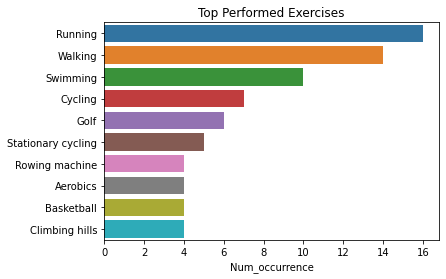

In [25]:
sns.barplot(y = 'Unique_exercise', x = 'Num_occurrence', dodge = False, data = top_five_cal)
plt.title("Top Performed Exercises")
plt.ylabel(None)

Running is the highest performed exercise, followed by walking, swimming, then cycling. We could notice that these are cardiovascular exercises which is considered as one of the most efficient exercise in burning calories.

**Top Exercise for Burning Calories**

To determine which exercise burns the most calories, we will need to sort the data by the number of calories burned in descending order. This will allow us to see which exercises burn the most calories at the top of the list. The next query would be about the exercise having greater than 1 occurrence in the dataset.

In [26]:
#top ten purely by calories burned per kg
top_five_purecal = pd.read_sql_query('''SELECT Unique_exercise, Mean_calories_per_kg, Num_occurrence 
                                        FROM Exercise_Data WHERE Num_occurrence > 1 
                                        ORDER BY Mean_calories_per_kg DESC LIMIT 5''', engine_df1)

Text(0, 0.5, '')

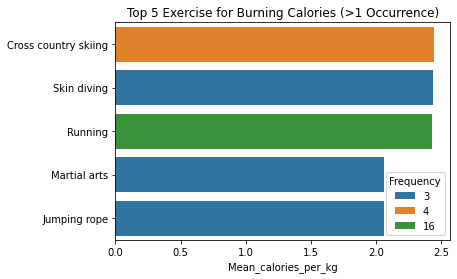

In [27]:
sns.barplot(y = 'Unique_exercise', x = 'Mean_calories_per_kg', hue = 'Num_occurrence', dodge = False, data = top_five_purecal)
plt.title("Top 5 Exercise for Burning Calories (>1 Occurrence)")
plt.legend(title="Frequency")
plt.ylabel(None)

Cross country skiing, skin diving, and running have the highest mean in terms of calories burned per kg, according to the bar graph. However, running appears 16 times in the dataset, so it is possible that the mean for running was affected by both low and high intensity running, which could skew its result.

In [28]:
# check top 5 of only one occurrence in exercise
top_five_one_occurrence = pd.read_sql_query('''SELECT Unique_exercise, Mean_calories_per_kg, Num_occurrence 
                                               FROM Exercise_Data WHERE Num_occurrence = 1 
                                               ORDER BY Mean_calories_per_kg DESC LIMIT 5''', engine_df1)

Text(0, 0.5, '')

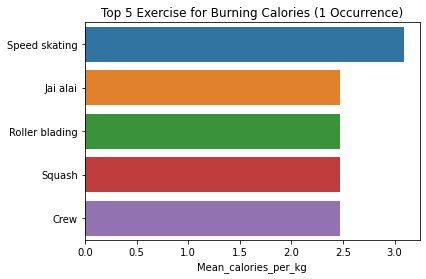

In [29]:
sns.barplot(y = 'Unique_exercise', x = 'Mean_calories_per_kg', data = top_five_one_occurrence)
plt.title("Top 5 Exercise for Burning Calories (1 Occurrence)")
plt.ylabel(None)

Among the exercises that have only one occurrence in the dataset, speed skating has the highest number of calories burned per kg, followed by jai alai, roller blading, squash, and crew.

**Exercise Intensity and Types Data**

The next step is to examine the intensity of exercises using the "Keyword" column. It is important to consider the number of times each keyword appears in the dataset because it could represent the general consensus on how people exercise.

In [30]:
top10_freq = pd.read_sql_query('''SELECT * FROM Frequency_Data ORDER BY Frequency DESC LIMIT 10''', engine_df2)
top10_freq

,index,Keyword,Frequency,Mean_calburned
0,8,moderate,14,1.335533
1,10,vigorous,12,1.776174
2,6,light,10,0.726830
3,23,general,9,0.949610
4,43,up,9,1.635940
5,47,competitive,8,1.802013
6,27,slow,7,0.867821
7,28,fast,7,1.926944
8,134,walk,7,0.759210
9,4,racing,6,1.990727


<AxesSubplot:xlabel='Frequency', ylabel='Keyword'>

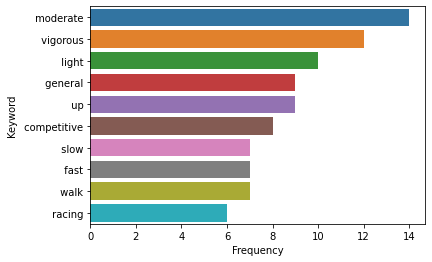

In [31]:
sns.barplot(x = 'Frequency', y = 'Keyword', data = top10_freq)

The graph shows that the most common intensity level in the dataset is moderate, followed by vigorous and then light. This is likely because many people prefer to exercise at a moderate intensity, as it allows them to maintain good overall fitness without straining their bodies too much or performing too lightly.

Next step is to look at the intensity or type of exercise that helps burn the most calories per kilogram.

In [32]:
top10_calburned = pd.read_sql_query('''SELECT * FROM Frequency_Data ORDER BY Mean_calburned DESC LIMIT 10''', engine_df2)
top10_calburned

,index,Keyword,Frequency,Mean_calburned
0,4,racing,6,1.990727
1,28,fast,7,1.926944
2,39,10.9 mph (5.5 min mile),2,1.853296
3,47,competitive,8,1.802013
4,10,vigorous,12,1.776174
5,0,bmx,1,1.750730
6,1,mountain bike,1,1.750730
7,14,very vigorous,3,1.681901
8,5,>20 mph,2,1.647487
9,38,10 mph (6 min mile),2,1.647487


<AxesSubplot:xlabel='Mean_calburned', ylabel='Keyword'>

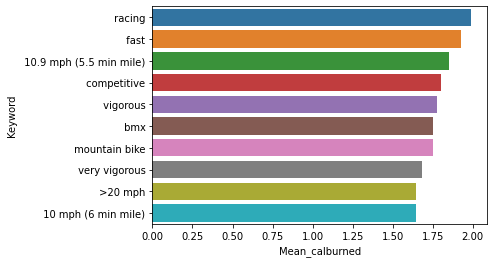

In [33]:
sns.barplot(x = 'Mean_calburned', y = 'Keyword', data = top10_calburned)

According to the graph, racing, fast, 10.9 mph (speed), and competitive activities have the highest likelihood of burning the most calories in terms of intensity. This suggests that higher intensity exercises have a greater potential to burn more calories than lower intensity exercises.

# Conclusions

Based on the data analyzed, it can be concluded that: 

1. Cardiovascular exercises, such as running and walking, are among the most frequently performed exercises due to their efficiency in achieving physical fitness and burning calories. 
2. Despite being simple, running and walking are effective at burning calories. 
3. Moderate intensity exercises are the most popular among people seeking to improve their physical fitness. 
4. To maximize calorie-burning potential, it is advisable to engage in vigorous and heart-pumping exercises.